In [ ]:
import chaospy



## Poisson equation
-d^2 u / dx^2 = f(x,w)
u(-1) = u(1) = 0

f(x,w) ~ GP(f0(x), k(x,x'))
f0(x) = 10 sin(pi x)
k(x,x') = \sigma^2*exp(-(x-x')^2 / l^2)

\sigma = 1 ; l = 0.5


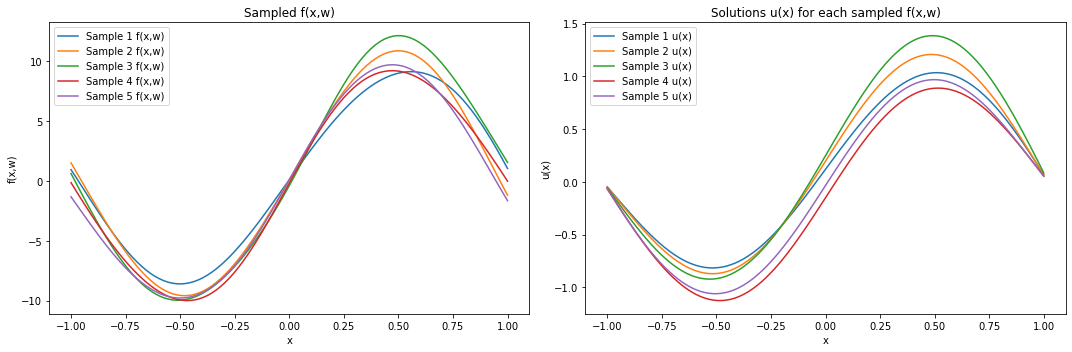

u[0] for each sample: [-0.04789031 -0.049632   -0.05694793 -0.06538918 -0.06666861]
u[-1] for each sample: [0.06645569 0.06704589 0.08410326 0.05420499 0.05304532]


In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Define parameters
sigma = 1
l = 0.5
n_points = 100
x = np.linspace(-1, 1, n_points)
dx = x[1] - x[0]

# Define the mean function and the kernel
f0 = lambda x: 10 * np.sin(np.pi * x)

def kernel(x, x_prime, sigma=sigma, l=l):
    return sigma**2 * np.exp(-((x-x_prime)**2) / l**2)

# Sample from the GP
def sample_GP(x, n_samples=1):
    mu = f0(x)
    K = np.array([[kernel(xi, xj) for xj in x] for xi in x])
    return np.random.multivariate_normal(mu, K, n_samples)

# Finite differences using scipy's sparse matrix to solve the Poisson equation

def solve_poisson(f, dx, u_left=0, u_right=0):
    N = len(f)
    diagonals = [-2 * np.ones(N), np.ones(N - 1), np.ones(N - 1)]
    A = diags(diagonals, [0, 1, -1], format="csr")
    A = A / dx**2

    # Set boundary conditions
    f[0] += u_left / dx**2
    f[-1] += u_right / dx**2

    u = spsolve(A, -f)
    return u


n_samples = 5
f_samples = sample_GP(x, n_samples)
u_solutions = np.array([solve_poisson(f_sample, dx) for f_sample in f_samples])

plt.figure(figsize=(15, 5))

# Left subplot for f(x,w)
plt.subplot(1, 2, 1)
for i in range(n_samples):
    plt.plot(x, f_samples[i], label=f"Sample {i+1} f(x,w)")
plt.title("Sampled f(x,w)")
plt.xlabel('x')
plt.ylabel('f(x,w)')
plt.legend()

# Right subplot for u(x)
plt.subplot(1, 2, 2)
for i in range(n_samples):
    plt.plot(x, u_solutions[i], label=f"Sample {i+1} u(x)")
plt.title("Solutions u(x) for each sampled f(x,w)")
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()

plt.tight_layout()
plt.show()

# Print u[0] and u[-1] for each sample

u_left_boundary = u_solutions[:, 0]
u_right_boundary = u_solutions[:, -1]

print(f"u[0] for each sample: {u_left_boundary}")
print(f"u[-1] for each sample: {u_right_boundary}")

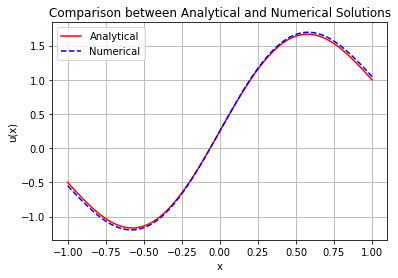

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Number of grid points
N = 100
x = np.linspace(-1, 1, N).reshape(-1, 1)

# Sinusoidal force
f_sinusoidal = 10 * np.sin(np.pi * x).flatten()

# Boundary conditions
u_left = -0.5
u_right = 1

# Analytical solution
def get_analytical_solution(x, u_left, u_right):
    # Particular solution
    u_p = 10 / np.pi**2 * np.sin(np.pi * x)
    
    # Solving for coefficients using boundary conditions
    # Given the sin and cos relationships at x = -1 and x = 1, we can simplify the system
    B = (u_left + u_right) / 2 
    A = (u_right - u_left) / 2
    
    u_h = A * x + B 
    
    return u_h + u_p

# Solve Poisson equation using finite differences with sparse matrices
def solve_poisson(f, dx, u_left, u_right):
    N = len(f)
    diagonals = [-2 * np.ones(N), np.ones(N - 1), np.ones(N - 1)]
    A = diags(diagonals, [0, 1, -1], format="csr")
    A = A / dx**2

    # Set boundary conditions
    f[0] += u_left / dx**2
    f[-1] += u_right / dx**2

    u = spsolve(A, -f)
    return u

dx = x[1] - x[0]
u_numerical = solve_poisson(f_sinusoidal, dx, u_left, u_right)
u_analytical = get_analytical_solution(x, u_left, u_right)
# Plotting
plt.plot(x, u_analytical, label='Analytical', color='red')
plt.plot(x, u_numerical, label='Numerical', linestyle='dashed', color='blue')
plt.title("Comparison between Analytical and Numerical Solutions")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.grid(True)
plt.show()

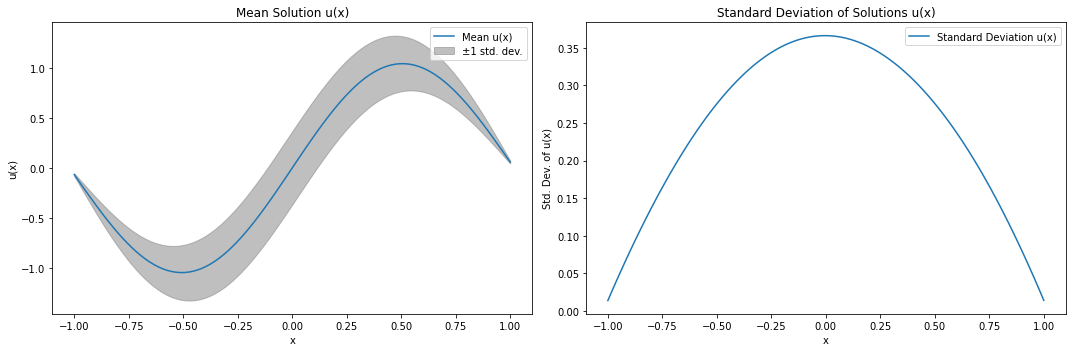

In [42]:
n_samples = 1000
f_samples = sample_GP(x, n_samples) # Matrix of shape (n_samples, n_points)
u_solutions = np.array([solve_poisson(f_sample, dx) for f_sample in f_samples]) # Matrix of shape (n_samples, n_points)

# Calculate the mean and standard deviation along the sample axis
u_mean = u_solutions.mean(axis=0)
u_std = u_solutions.std(axis=0)

# Plot the mean and standard deviation side by side
plt.figure(figsize=(15, 5))

# Left subplot for mean of u(x)
plt.subplot(1, 2, 1)
plt.plot(x, u_mean, label="Mean u(x)")
plt.fill_between(x, u_mean - u_std, u_mean + u_std, color='gray', alpha=0.5, label="±1 std. dev.")
plt.title("Mean Solution u(x)")
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()

# Right subplot for standard deviation of u(x)
plt.subplot(1, 2, 2)
plt.plot(x, u_std, label="Standard Deviation u(x)")
plt.title("Standard Deviation of Solutions u(x)")
plt.xlabel('x')
plt.ylabel('Std. Dev. of u(x)')
plt.legend()

plt.tight_layout()
plt.show()

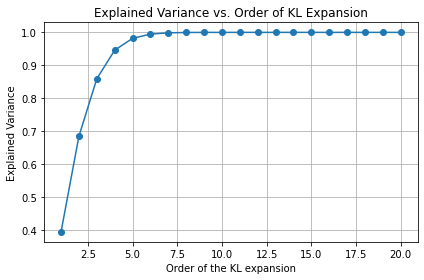

Suggested truncation order for 99.0% explained variance: 6


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# Define the GP kernel
def kernel(x, x_prime, sigma=sigma, l=l):
    return sigma**2 * np.exp(-((x-x_prime)**2) / l**2)

# Compute the covariance matrix for the grid points
K = np.array([[kernel(xi, xj) for xj in x] for xi in x])

# Compute the eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = eigh(K)

# Sort eigenvalues in decreasing order and their associated eigenvectors
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Compute the cumulative explained variance
explained_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)

# Plot explained variance
plt.figure()
n_orders = 20
plt.plot(np.arange(1, n_orders + 1), explained_variance[:n_orders], marker='o')
plt.xlabel('Order of the KL expansion')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs. Order of KL Expansion')
plt.grid(True)
plt.tight_layout()
plt.show()

# Propose truncation order based on a threshold
threshold = 0.99  # Example threshold for 95% explained variance
truncation_order = np.argmax(explained_variance >= threshold) + 1
print(f"Truncation order for {threshold*100}% explained variance: {truncation_order}")


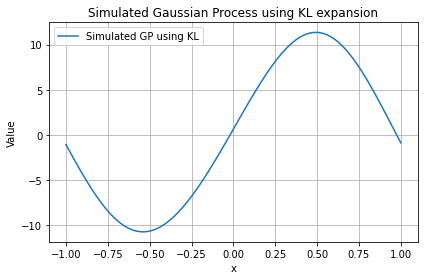

In [46]:
def simulate_gp_with_kl(x, eigenvectors, eigenvalues, truncation_order):
    """Simulate the Gaussian Process using the KL expansion."""
    # Generate standard normal random variables
    xi = np.random.randn(truncation_order)
    
    # KL expansion
    kl_terms = np.sqrt(eigenvalues[:truncation_order]) * xi @ eigenvectors[:, :truncation_order].T
    return f0(x) + kl_terms

# Simulate the GP using the KL expansion
simulated_gp = simulate_gp_with_kl(x, eigenvectors, eigenvalues, truncation_order)

plt.figure()
plt.plot(x, simulated_gp, label='Simulated GP using KL')
plt.xlabel('x')
plt.ylabel('Value')
plt.title('Simulated Gaussian Process using KL expansion')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim

# Ensure reproducibility
torch.manual_seed(0)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [128]:
def hermite_polynomial(order, xi):
    """Compute the Hermite polynomial of a given order for xi."""
    if order == 0:
        return torch.ones_like(xi)
    elif order == 1:
        return xi
    else:
        H0 = torch.ones_like(xi)
        H1 = xi
        for _ in range(2, order + 1):
            H_next = xi * H1 - (order - 1) * H0
            H0, H1 = H1, H_next
        return H1

def generate_pce_basis(xi, max_order):
    """Generate PCE basis up to a given order for xi."""
    basis = []
    for order in range(max_order + 1):
        basis.append(hermite_polynomial(order, xi))
    return torch.stack(basis, dim=-1)

class MeanNN(nn.Module):
    """Neural network to approximate the mean function."""
    def __init__(self, input_dim, hidden_dim=4):
        super(MeanNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)
        return x


class PCECoefficientNN(nn.Module):
    """Neural network to approximate the coefficients of the PCE."""
    def __init__(self, input_dim, hidden_dim=32, output_dim=None):
        super(PCECoefficientNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

    
def compute_loss(x, xi,f, mean_model, coeffs_model, batch_size):

    indices = torch.randperm(xi.size(0))[:batch_size]
    xi_batch = xi[indices]
    f_batch = f.T[indices]
    loss = 0
    for i in range(batch_size):
        xi_sample = xi_batch[i, :]
    # Compute the PCE basis
        pce_basis = hermite_polynomial(1, xi_sample)

        # Total predicted u
        u_predicted = mean_model(x) + coeffs_model(x) @ pce_basis.T
        # 1st derivative of u wrt x
        du_dx = torch.autograd.grad(u_predicted.sum(), x, create_graph=True)[0]
        
        # 2nd derivative of u wrt x (Laplacian in 1D)
        d2u_dx2 = torch.autograd.grad(du_dx.sum(), x, create_graph=True)[0]
    
    
        # PDE Residual Loss: -d^2u/dx^2 - f(x, w)
        pde_residual = d2u_dx2 + f_batch[i, :]
        pde_loss = torch.mean(pde_residual**2)

        # # Boundary Conditions Loss
        bc_loss_left = u_predicted[0]**2
        bc_loss_right = u_predicted[-1]**2
        bc_loss = bc_loss_left + bc_loss_right

        # Combine the losses
        loss += bc_loss
    
    return loss

In [127]:
x_train.requires_grad = True
xi_sample = xi_train[0, :]

batch_size = 100

indices = torch.randperm(xi_train.size(0))[:batch_size]
xi_batch = xi_train[indices]
# f_batch = f[indices]

# Compute the PCE basis
pce_basis = hermite_polynomial(1, xi_sample)

# Total predicted u
u_predicted = mean_model(x_train) + coeffs_model(x_train) @ pce_basis.unsqueeze(0).T

print(f"mean shape: {mean_model(x_train).shape}")
print(f"coeffs shape: {coeffs_model(x_train).shape}")
print(f"pce_basis shape: {pce_basis.shape}")
print(f"u_predicted shape: {u_predicted.sum().shape}")
# # 1st derivative of u wrt x
du_dx = torch.autograd.grad(u_predicted.sum(), x_train, create_graph=True)[0]
print(f"du_dx shape: {du_dx.shape}")
# 2nd derivative of u wrt x (Laplacian in 1D)
d2u_dx2 = torch.autograd.grad(du_dx.sum(), x_train, create_graph=True)[0]


# PDE Residual Loss: -d^2u/dx^2 - f(x, w)
pde_residual = d2u_dx2 + f_train[0, :]
pde_loss = torch.mean(pde_residual**2)

# Boundary Conditions Loss
bc_loss_left = u_predicted[0]**2
bc_loss_right = u_predicted[-1]**2
bc_loss = bc_loss_left + bc_loss_right

# Combine the losses
loss = pde_loss + bc_loss

mean shape: torch.Size([10, 1])
coeffs shape: torch.Size([10, 6])
pce_basis shape: torch.Size([6])
u_predicted shape: torch.Size([])
du_dx shape: torch.Size([10, 1])


In [83]:
# pce_basis = hermite_polynomial(1, xi_train)
# print(pce_basis.T.shape)
# print(coeffs_model(x_train).shape)
# print( (coeffs_model(x_train) @ pce_basis.T).shape)

# print( mean_model(x_train).repeat(1, 1000).shape)
# print( (mean_model(x_train)* torch.ones_like(pce_basis)).shape)

u_predicted = mean_model(x_train).repeat(1, 1000) + coeffs_model(x_train) @ pce_basis.T
du_dx = torch.autograd.grad(u_predicted, x_train, create_graph=True)[0]
d2u_dx2 = torch.autograd.grad(du_dx, x_train, create_graph=True)[0]

print(d2u_dx2.shape)


RuntimeError: grad can be implicitly created only for scalar outputs

In [129]:
n_sensors = 10

xi_train = torch.randn((1000, truncation_order)).to(device)  # 1000 samples, `truncation_order` random variables
x_train = torch.linspace(-1, 1, n_sensors).unsqueeze(-1).to(device)  # Corresponding x values

def f_from_xi(xi, x_train):
    xi = xi.cpu().numpy()
    x_train = x_train.cpu().numpy()
    kl_terms = np.sqrt(eigenvalues[:truncation_order]) * xi @ eigenvectors[:, :truncation_order].T
    return f0(x_train) + [kl_terms[int(i)] for i in np.linspace(0, len(kl_terms)-1, n_sensors)]

f_train = torch.tensor(f_from_xi(xi_train,x_train)).to(device)
x_train.requires_grad = True

# Models, Loss, and Optimizer
mean_model = MeanNN(input_dim=1).to(device)
coeffs_model = PCECoefficientNN(input_dim=1, output_dim=truncation_order).to(device)
optimizer = optim.Adam(list(mean_model.parameters()) + list(coeffs_model.parameters()), lr=0.001)


# Training loop
epochs = 1000
for epoch in range(epochs):
    mean_model.train()
    coeffs_model.train()
    optimizer.zero_grad()

    # Forward passes
    mean_predicted = mean_model(x_train)
    coeffs_predicted = coeffs_model(x_train)

    # Compute the combined loss
    loss = compute_loss(x_train, xi_train,f_train, mean_model, coeffs_model, batch_size=1000)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')


IndexError: index 240 is out of bounds for dimension 0 with size 100

In [61]:
n_sensors = 10

xi_train = torch.randn((1000, truncation_order)).to(device)  # 1000 samples, `truncation_order` random variables
x_train = torch.linspace(-1, 1, n_sensors).unsqueeze(-1).to(device)  # Corresponding x values

def f(x, xi):
    """PDE forcing function."""
    # KL expansion
    xi = xi.cpu().numpy()
    kl_terms = np.sqrt(eigenvalues[:truncation_order]) * xi @ eigenvectors[:, :truncation_order].T
    return f0(x) + kl_terms

f(x_train, xi_train).shape

ValueError: operands could not be broadcast together with shapes (10,1) (1000,100) 